<a href="https://colab.research.google.com/github/Ouardavalue/EDP/blob/master/EDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

In [0]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from plotly.subplots import make_subplots

In [0]:

#Electric cars chargings Points optimal location
#Domain Energy & Environment

#Identify the optimal points where to install the electric vehicule cchargings points
#EDP is a company that leads the energy sector. in spain, EDP is present in generation, distribution and commercialization of electricity , gas and services.

#the goal is to identify the optimal points where to install the electric vehicule chargings. EDP is now expandings its public charging infrastructure and it is of high importance where to place the nex chargings points.
#the decision will be based on the location of existing points, the trafic information and matriculation of existing cars plus projection of electric cars in the future.

#need spanish traffic information
#EDP own public infrastructure data

#the objective of this challenge is to develop a predictive Model which based on the inputs included in the datasets generates the charging points optimal location. the algorithm should be able of deciding where EDP should install its charging points.
#the best is to have a dashbord that shows in the best possible way the result of the predictive model.

#File loading

In [0]:
# code qui permet en cas de changement de chemin du repertoire root, pour eviter de retaper tout le chemin
#fonction utilisée: concatenantion
data_dir = './gdrive/My Drive/edp_data/'
mat_file = data_dir + 'matricules.xlsx'
points_file = data_dir + 'PuntosRecarga.xlsx'
provincia_file = data_dir + 'provincia_listado.xlsx'
impagos_file = data_dir + 'impagos.xlsx'

In [0]:
#matricules.xlxs
mat_cols = ['Categoria_veh_elect', 'Año', 'Mercado', 'Marca', 'Modelo', 'Provincia', 'Canal']
df_matricules = pd.read_excel(mat_file,
                              usecols=mat_cols)

"Canal" : Particular/Empressa/Alquilador

In [0]:
#provincia_listado.xlsx
prov_cols = ['Autonomia', 'Superficie', 'PROVINCIA']
df_provincia = pd.read_excel(provincia_file,
                             usecols=prov_cols)

In [0]:
#impagos.xlsx
impagos_cols = ['CONSUMO_ELECTRICO_ANUAL', 'PROVINCIA', 'TIPO_CLIENTE']
df_impagos = pd.read_excel(impagos_file,
                           usecols=impagos_cols)

In [0]:
#PuntosRecarga.xlsx
df_points = pd.read_excel(points_file)

In [0]:
df_impagos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CONSUMO_ELECTRICO_ANUAL  1051 non-null   float64
 1   PROVINCIA                1051 non-null   object 
 2   TIPO_CLIENTE             1051 non-null   object 
dtypes: float64(1), object(2)
memory usage: 24.8+ KB


In [0]:
df_matricules.info()
   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Categoria_veh_elect  130 non-null    object
 1   Año                  130 non-null    int64 
 2   Mercado              130 non-null    object
 3   Marca                130 non-null    object
 4   Modelo               130 non-null    object
 5   Provincia            130 non-null    object
 6   Canal                130 non-null    object
dtypes: int64(1), object(6)
memory usage: 7.2+ KB


In [0]:
df_provincia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PROVINCIA   52 non-null     object 
 1   Superficie  52 non-null     float64
 2   Autonomia   52 non-null     object 
dtypes: float64(1), object(2)
memory usage: 1.3+ KB


In [0]:
df_points.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   grupo               153 non-null    object 
 1   organizacion        153 non-null    object 
 2   SuperCPO            156 non-null    object 
 3   GrupoCargadoresCPO  156 non-null    object 
 4   region              156 non-null    object 
 5   zona                156 non-null    object 
 6   ubicacion           156 non-null    object 
 7   latitud             156 non-null    float64
 8   longitud            156 non-null    float64
 9   posteRecarga        156 non-null    object 
 10  toma                154 non-null    object 
dtypes: float64(2), object(9)
memory usage: 13.5+ KB


# Data Preprocessing

In [0]:
def match_region_name(reg_src, list_reg):
  """
  Matches composite names which appears in a different order
  e.g. 'Principade de Asturias' and 'Asturias Principado de'
  """
  l_src = reg_src.split()

  if len(l_src) == 1:
    return reg_src

  l = list(map(str.split, list_reg))
  l = [i for i in l if len(i) > 1]
  return ' '.join(next((s for s in l if set(l_src) == set(s)), reg_src.split()))

def replace_whole_str(sub, l):
  return next((s for s in l if sub in s), sub)

In [0]:
#Normalisation des regions du fichier points
df_points['region'] = df_points['region'].str.lower()
df_points['region'] = df_points['region'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df_points['region'].unique()

array(['principado de asturias', 'pais vasco', 'comunidad valenciana',
       'cantabria', 'castilla y leon', 'region de murcia', 'andalucia'],
      dtype=object)

In [0]:
#Normalisation des noms de provinces du fichier provincia_listado
df_provincia['PROVINCIA'] = df_provincia['PROVINCIA'].str.lower()
df_provincia['PROVINCIA'] = df_provincia['PROVINCIA'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df_provincia['PROVINCIA'] = df_provincia['PROVINCIA'].str.replace('\(|\)', '', regex=True)

df_provincia['Autonomia'] = df_provincia['Autonomia'].str.lower()
df_provincia['Autonomia'] = df_provincia['Autonomia'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

df_provincia['Autonomia'] = df_provincia['Autonomia'].str.replace('\(|\)', '', regex=True)
df_provincia['Autonomia'] = df_provincia['Autonomia'].apply(lambda x : match_region_name(x, df_points['region'].unique()))
df_provincia['Autonomia'].unique()

array(['pais vasco', 'castilla-la mancha', 'comunidad valenciana',
       'andalucia', 'castilla y leon', 'extremadura', 'balears illes',
       'cataluna', 'galicia', 'aragon', 'rioja la', 'madrid comunidad de',
       'region de murcia', 'navarra comunidad foral de',
       'principado de asturias', 'canarias', 'cantabria',
       'ceuta ciudad de', 'melilla ciudad de'], dtype=object)

In [0]:
#Impagos normalisation
df_impagos['PROVINCIA'] = df_impagos['PROVINCIA'].str.lower()
df_impagos['PROVINCIA'] = df_impagos['PROVINCIA'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
#df_impagos['PROVINCIA'] = df_impagos['PROVINCIA'].apply(lambda x : x.replace(' / ', '/'))
df_impagos['PROVINCIA'] = df_impagos['PROVINCIA'].str.replace(' / ', '/')
df_impagos['PROVINCIA'] = df_impagos['PROVINCIA'].apply(lambda x : replace_whole_str(x, df_provincia['PROVINCIA'].unique()))
df_impagos['PROVINCIA'] = df_impagos['PROVINCIA'].apply(lambda x : match_region_name(x, df_provincia['PROVINCIA'].unique()))
df_impagos['PROVINCIA'].unique()

array(['asturias', 'leon', 'navarra', 'baleares', 'madrid', 'toledo',
       'alicante/alacant', 'zaragoza', 'salamanca', 'valladolid',
       'cantabria', 'valencia/valencia', 'araba/alava', 'murcia',
       'gerona', 'bizkaia', 'barcelona', 'badajoz', 'gipuzkoa', 'jaen',
       'palencia', 'rioja la', 'lerida', 'sevilla', 'albacete', 'granada',
       'huelva', 'cordoba', 'guadalajara'], dtype=object)

In [0]:
df_provincia['PROVINCIA'].unique()

array(['araba/alava', 'albacete', 'alicante/alacant', 'almeria', 'avila',
       'badajoz', 'balears illes', 'barcelona', 'burgos', 'caceres',
       'cadiz', 'castellon/castello', 'ciudad real', 'cordoba',
       'coruna la', 'cuenca', 'girona', 'granada', 'guadalajara',
       'gipuzkoa', 'huelva', 'huesca', 'jaen', 'leon', 'lleida',
       'rioja la', 'lugo', 'madrid', 'malaga', 'murcia', 'navarra',
       'ourense', 'asturias', 'palencia', 'palmas las', 'pontevedra',
       'salamanca', 'santa cruz de tenerife', 'cantabria', 'segovia',
       'sevilla', 'soria', 'tarragona', 'teruel', 'toledo',
       'valencia/valencia', 'valladolid', 'bizkaia', 'zamora', 'zaragoza',
       'ceuta', 'melilla'], dtype=object)

In [0]:
#Normalisation des noms des provinces du fichier matricules
df_matricules['Provincia'] = df_matricules['Provincia'].apply(lambda x : x.strip().lower())
df_matricules['Provincia'] = df_matricules['Provincia'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df_matricules['Provincia'] = df_matricules['Provincia'].str.replace('\(|\)', '', regex=True)
df_matricules['Provincia'] = df_matricules['Provincia'].apply(lambda x : replace_whole_str(x, df_provincia['PROVINCIA'].unique()))
df_matricules['Provincia'].unique()

array(['araba/alava', 'sta. cruz tenerife', 'murcia', 'valladolid',
       'huelva', 'alicante/alacant', 'castellon/castello', 'ciudad real',
       'coruna la', 'gerona', 'guadalajara', 'huesca', 'madrid',
       'navarra', 'palmas las', 'pontevedra', 'tarragona', 'zaragoza',
       'albacete', 'almeria', 'badajoz', 'burgos', 'cantabria', 'cordoba',
       'guipuzcoa', 'sevilla', 'barcelona', 'asturias', 'baleares',
       'leon', 'salamanca', 'toledo', 'valencia/valencia', 'rioja la',
       'malaga', 'vizcaya', 'granada', 'cadiz', 'lugo', 'jaen', 'lerida',
       'orense'], dtype=object)

In [0]:
#Sanity check
try:
  assert set(df_matricules['Provincia'].unique()).issubset(set(df_provincia['PROVINCIA'].unique()))
  print('Provincia names from matricules.xlsx MATCH names from provincia_listado.xlsx')
except AssertionError:
  print('Provincia names from matricules.xlsx DO NOT MATCH names from provincia_listado.xlsx')

print('#'*50)

try:
  assert(set(df_points['region'].unique()).issubset(set(df_provincia['Autonomia'].unique())))
  print('Autonomia names from PuntosRecarga MATCH names from provincia_listado.xlsx')
except AssertionError:
  print('Autonomia names from PuntosRecarga.xlsx DO NOT MATCH names from provincia_listado.xlsx')

print('#'*50)

try:
  assert(set(df_impagos['PROVINCIA'].unique()).issubset(set(df_provincia['PROVINCIA'].unique())))
  print('Provincia names from impagos.xlsx MATCH names from  provincia_listado.xlsx')
except AssertionError:
  print('Provincia names from impagos.xlsx DO NOT MATCH names from  provincia_listado.xlsx')

Provincia names from matricules.xlsx DO NOT MATCH names from provincia_listado.xlsx
##################################################
Autonomia names from PuntosRecarga MATCH names from provincia_listado.xlsx
##################################################
Provincia names from impagos.xlsx DO NOT MATCH names from  provincia_listado.xlsx


In [0]:
# cette celule est à enlever éventuellement
# Get not matching elements
print(set(df_matricules['Provincia'].unique()).difference(set(df_provincia['PROVINCIA'].unique())))


{'sta. cruz tenerife', 'baleares', 'orense', 'guipuzcoa', 'vizcaya', 'lerida', 'gerona'}


In [0]:
#Join matricules w/ provincia to add Autonomia
df_merged_w_provincia= df_matricules.merge(df_provincia,
                                left_on='Provincia',
                                right_on='PROVINCIA')

In [0]:
df_merged_w_provincia.head()

,Categoria_veh_elect,Año,Mercado,Marca,Modelo,Provincia,Canal,PROVINCIA,Superficie,Autonomia
0,BEV,2018,Automoviles,VOLKSWAGEN,E-GOLF 3P/5P,araba/alava,Particular,araba/alava,3042.44,pais vasco
1,BEV,2019,Automoviles,VOLKSWAGEN,E-GOLF 3P/5P,araba/alava,Empresa,araba/alava,3042.44,pais vasco
2,PHEV,2019,Automoviles,VOLKSWAGEN,GOLF 1.4 GTE,araba/alava,Empresa,araba/alava,3042.44,pais vasco
3,BEV,2018,Automoviles,VOLKSWAGEN,E-UP! 3P,murcia,Particular,murcia,11313.88,region de murcia
4,BEV,2019,Automoviles,VOLKSWAGEN,E-GOLF 3P/5P,murcia,Empresa,murcia,11313.88,region de murcia


In [0]:
df_merged_w_provincia.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108 entries, 0 to 107
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Categoria_veh_elect  108 non-null    object 
 1   Año                  108 non-null    int64  
 2   Mercado              108 non-null    object 
 3   Marca                108 non-null    object 
 4   Modelo               108 non-null    object 
 5   Provincia            108 non-null    object 
 6   Canal                108 non-null    object 
 7   PROVINCIA            108 non-null    object 
 8   Superficie           108 non-null    float64
 9   Autonomia            108 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 9.3+ KB


In [0]:
#Join points w/ matricules
df_merged_w_points = df_merged_w_provincia.merge(df_points,
                                                 how='left',
                                                 left_on='Autonomia',
                                                 right_on='region')

In [0]:
#Df n'ayant pas de bornes dans la même regions que les voitures
#df_merged_w_points[df_merged_w_points['zona'].isnull()].info() # 56 entries
df_merged_w_points[df_merged_w_points['zona'].isnull()].head()

,Categoria_veh_elect,Año,Mercado,Marca,Modelo,Provincia,Canal,PROVINCIA,Superficie,Autonomia,grupo,organizacion,SuperCPO,GrupoCargadoresCPO,region,zona,ubicacion,latitud,longitud,posteRecarga,toma
87,BEV,2019,Automoviles,VOLKSWAGEN,E-GOLF 3P/5P,ciudad real,Empresa,ciudad real,19662.78,castilla-la mancha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,BEV,2019,Automoviles,VOLKSWAGEN,E-GOLF 3P/5P,coruna la,Particular,coruna la,7910.76,galicia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,PHEV,2018,Automoviles,VOLKSWAGEN,GOLF 1.4 GTE,coruna la,Empresa,coruna la,7910.76,galicia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,PHEV,2019,Automoviles,VOLKSWAGEN,PASSAT 1.4 GTE 4P (B6),coruna la,Empresa,coruna la,7910.76,galicia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,BEV,2019,Automoviles,VOLKSWAGEN,E-GOLF 3P/5P,coruna la,Empresa,coruna la,7910.76,galicia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
#Df bornes présentes dans la même région que les voitures
#df_merged_w_points[df_merged_w_points['zona'].notnull()].info() # 868 entries
df_merged_w_points[df_merged_w_points['zona'].notnull()].head()

,Categoria_veh_elect,Año,Mercado,Marca,Modelo,Provincia,Canal,PROVINCIA,Superficie,Autonomia,grupo,organizacion,SuperCPO,GrupoCargadoresCPO,region,zona,ubicacion,latitud,longitud,posteRecarga,toma
0,BEV,2018,Automoviles,VOLKSWAGEN,E-GOLF 3P/5P,araba/alava,Particular,araba/alava,3042.44,pais vasco,Edp Moveon,EDP,EDP moveon,EDP Moveon,pais vasco,Vitoria,País Vasco,42.860120,-2.703290,Vitorialanda,CCS Combo 2 Plug (Cable Attached)
1,BEV,2018,Automoviles,VOLKSWAGEN,E-GOLF 3P/5P,araba/alava,Particular,araba/alava,3042.44,pais vasco,Edp Moveon,EDP,EDP moveon,EDP Moveon,pais vasco,Vitoria,País Vasco,42.860120,-2.703290,Vitorialanda,CHAdeMO
2,BEV,2018,Automoviles,VOLKSWAGEN,E-GOLF 3P/5P,araba/alava,Particular,araba/alava,3042.44,pais vasco,Edp Moveon,EDP,EDP moveon,EDP Moveon,pais vasco,Vitoria,País Vasco,42.860120,-2.703290,Vitorialanda,Type 2 Connector (Cable Attached)
3,BEV,2018,Automoviles,VOLKSWAGEN,E-GOLF 3P/5P,araba/alava,Particular,araba/alava,3042.44,pais vasco,EDP Mantenimiento,Mantenimiento,EDP moveon,EDP Moveon,pais vasco,Bergara,País Vasco,43.107969,-2.406641,Avia - Bergara,CHAdeMO
4,BEV,2018,Automoviles,VOLKSWAGEN,E-GOLF 3P/5P,araba/alava,Particular,araba/alava,3042.44,pais vasco,ISASTUR,Mantenimiento,EDP moveon,EDP Moveon,pais vasco,Murguía,País Vasco,42.961774,-2.827486,Murguía,CHAdeMO


#Exploratory Data Analysis

##Data matricules/points

In [0]:
#Nombre de bornes par region
df_point_per_region = df_points['region'].value_counts().rename_axis('region').reset_index(name='count_point')
df_point_per_region

,region,count_point
0,principado de asturias,124
1,comunidad valenciana,10
2,pais vasco,7
3,cantabria,5
4,castilla y leon,4
5,andalucia,4
6,region de murcia,2


In [0]:
#Nb matricule par region
df_veh_per_region = df_merged_w_provincia.groupby('Autonomia').agg({'Categoria_veh_elect': 'count'}).reset_index()
df_veh_per_region

,Autonomia,Categoria_veh_elect
0,andalucia,21
1,aragon,5
2,canarias,6
3,cantabria,1
4,castilla y leon,7
5,castilla-la mancha,6
6,cataluna,13
7,comunidad valenciana,10
8,extremadura,1
9,galicia,8


In [0]:
#Par region, nombre de bornes et voiture (Left Join)
df_merged = df_provincia.merge(df_point_per_region, how='left', left_on='Autonomia', right_on='region')\
                        .merge(df_veh_per_region, how='left', on='Autonomia')
df_merged = df_merged[['Autonomia', 'count_point', 'Categoria_veh_elect']].drop_duplicates().fillna(0)
df_merged.rename(columns={'Categoria_veh_elect': 'count_veh'}, inplace=True)
df_merged

,Autonomia,count_point,count_veh
0,pais vasco,7.0,3.0
1,castilla-la mancha,0.0,6.0
2,comunidad valenciana,10.0,10.0
3,andalucia,4.0,21.0
4,castilla y leon,4.0,7.0
5,extremadura,0.0,1.0
6,balears illes,0.0,0.0
7,cataluna,0.0,13.0
14,galicia,0.0,8.0
21,aragon,0.0,5.0


In [0]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 51
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Autonomia    19 non-null     object 
 1   count_point  19 non-null     float64
 2   count_veh    19 non-null     float64
dtypes: float64(2), object(1)
memory usage: 608.0+ bytes


In [0]:
x = df_merged['Autonomia'].values.tolist()
fig = make_subplots(rows=2, cols=1, 
                    subplot_titles=['Number of vehicle per autonomia', 'Number of points per autonomia'])

#Number of vehicle per autonomia
fig.add_trace(go.Bar(x=x, y=df_merged['count_veh'].values.tolist(), text=df_merged['count_veh'].values.tolist(), textposition='outside', name='nb_vehicle'),
              row=1,
              col=1)


#Number of points per autonomia
fig.add_trace(go.Bar(x=x, y=df_merged['count_point'].values.tolist(), text=df_merged['count_point'].values.tolist(), textposition='outside', name='nb_poins'),
              row=2,
              col=1)

fig.update_layout(height=900, width=1300)
fig.show()

In [0]:
df_veh_per_marca = df_matricules.groupby('Marca').agg({'Categoria_veh_elect': 'count'}).reset_index()
df_veh_per_marca

,Marca,Categoria_veh_elect
0,VOLKSWAGEN,130


The number of vehicle is low and contains only Volkswagen cars for some reason. </br>
This file must be incomplete.

In [0]:
autonomias = df_merged['Autonomia'].unique()

fig = go.Figure(data=[
    go.Bar(name='nb_points', x=autonomias, y=df_merged['count_point']),
    go.Bar(name='nb_vehicles', x=autonomias, y=df_merged['count_veh'])
])
# Change the bar mode
fig.update_layout(title='Number of points and vehicle per autonomia', barmode='group')
fig.show()

We can see that some cities have electrical vehicles but don't have charging points. <br/>
Notice that Asturias has too many charging points (120+ points for 10- vehicles)

## Data Impagos

In [0]:
s_counts = df_impagos['PROVINCIA'].value_counts()
data = {'PROVINCIA': s_counts.index.tolist(), 
        'count_veh': s_counts.values.tolist()}
df_counts = pd.DataFrame(data, columns=['PROVINCIA', 'count_veh'])

In [0]:
y = df_counts['count_veh'].values.tolist()

fig = go.Figure(go.Bar(x=df_counts['PROVINCIA'].values.tolist(),
                       y=y,
                       text=y,
                       textposition='outside'))

fig.update_layout(title='Number of vehicle per autonomia according impagos file')
fig.show()

This barplot show electric/hybrid car users. Most of the customers are from Asturias, which is expected. <br/>
As shown above, Asturias has most of the charging points but in this file, we have more users coming from there. <br/>

In [0]:
df_impagos = df_impagos[df_impagos['TIPO_CLIENTE'].isin(['ELEC', 'DUAL'])]
df_impagos_consumo = df_impagos.groupby('PROVINCIA').agg({'CONSUMO_ELECTRICO_ANUAL': 'sum'}).reset_index()
df_impagos = df_impagos.merge(df_provincia, on='PROVINCIA')
df_impagos = df_impagos.groupby('Autonomia').agg({'CONSUMO_ELECTRICO_ANUAL': 'sum'}).reset_index()
df_impagos.sort_values('CONSUMO_ELECTRICO_ANUAL', inplace=True)

In [0]:
#Plot electrical consumption per autonomia
y = df_impagos_consumo['CONSUMO_ELECTRICO_ANUAL'].values.tolist()

fig = go.Figure(go.Bar(x=df_impagos_consumo['Autonomia'].values.tolist(),
                       y=y,
                       text=y,
                       textposition='outside',
                       texttemplate='%{y:2.2f}'))

fig.update_layout(title='Electrical consumption per autonomia')
fig.show()

In [0]:
#labels = df_provincia.Autonomia.drop_duplicates().tolist()
labels = df_merged.Autonomia.drop_duplicates().tolist()
x = [0] * len(labels) 
for index_i, row_i in df_merged.iterrows():
    if row_i["Autonomia"] in labels:
        x[labels.index(row_i["Autonomia"])] == row_i["count_point"]
    else: 
        print("Autonomia not found : {}".format(row_i))

In [0]:
import plotly.express as px

fig = px.pie(df_merged[["Autonomia", "count_veh"]], values='count_veh', names='Autonomia', title='Distribution of cars', hole=.1)
fig.update_traces(textposition='inside', textinfo='value+percent+label')

fig.show()

In [0]:
import plotly.express as px

fig = px.pie(df_merged[["Autonomia", "count_point"]], values='count_point', names='Autonomia', title='Distribution of Points', hole=.1)
fig.update_traces(textposition='inside', textinfo='value+percent+label')

fig.show()

In [0]:


print(labels,x)    
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=1)

fig = make_subplots(rows=1, cols=1, subplot_titles=['Pie Chart'])
fig.add_trace(go.Pie(values=x, labels=labels, name="Points Number"),1, 1)
#fig.add_trace(go.Bar(x=x, y=df_merged['count_point'].values.tolist(), text=df_merged['count_point'].values.tolist(), textposition='outside', name='nb_poins'), row=2,col=1)


# Use `hole` to create a donut-like pie chart
#fig.update_traces(hole=.5, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Pie Chart",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Pie Chart', x=0.18, y=0.5, font_size=20, showarrow=False)])

#fig.update_layout(height=900, width=1300)
fig.show()

# pour les différents type de bornes

['pais vasco', 'castilla-la mancha', 'comunidad valenciana', 'andalucia', 'castilla y leon', 'extremadura', 'balears illes', 'cataluna', 'galicia', 'aragon', 'rioja la', 'madrid comunidad de', 'region de murcia', 'navarra comunidad foral de', 'principado de asturias', 'canarias', 'cantabria', 'ceuta ciudad de', 'melilla ciudad de'] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


ValueError: ignored

## Exploring distances between points

 1 - Looking the distribution of distance between points

In [0]:
# Plot distances between pooint to see if it's something relevant 
# for each point compute distance with the closet other point
df_points_dist = df_merged_w_points[["Autonomia","zona","latitud", "longitud"]]
df_points_dist = df_points_dist.dropna().drop_duplicates()
df_points_dist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 0 to 306
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Autonomia  119 non-null    object 
 1   zona       119 non-null    object 
 2   latitud    119 non-null    float64
 3   longitud   119 non-null    float64
dtypes: float64(2), object(2)
memory usage: 4.6+ KB


In [0]:
import geopy.distance
distance_list = []
for index_i, row_i in df_points_dist.iterrows() :
    list_dist = [geopy.distance.vincenty((row_i["latitud"], row_i["longitud"]), (row_j["latitud"], row_j["longitud"])).km 
                 for index_j, row_j in df_points_dist.iterrows() if index_i != index_j 
                 ]
    distance_list.append(min(list_dist)) 
df_points_dist["distances"] = distance_list


Text(0.5, 1.0, 'Boxplot for nearest distances between points')

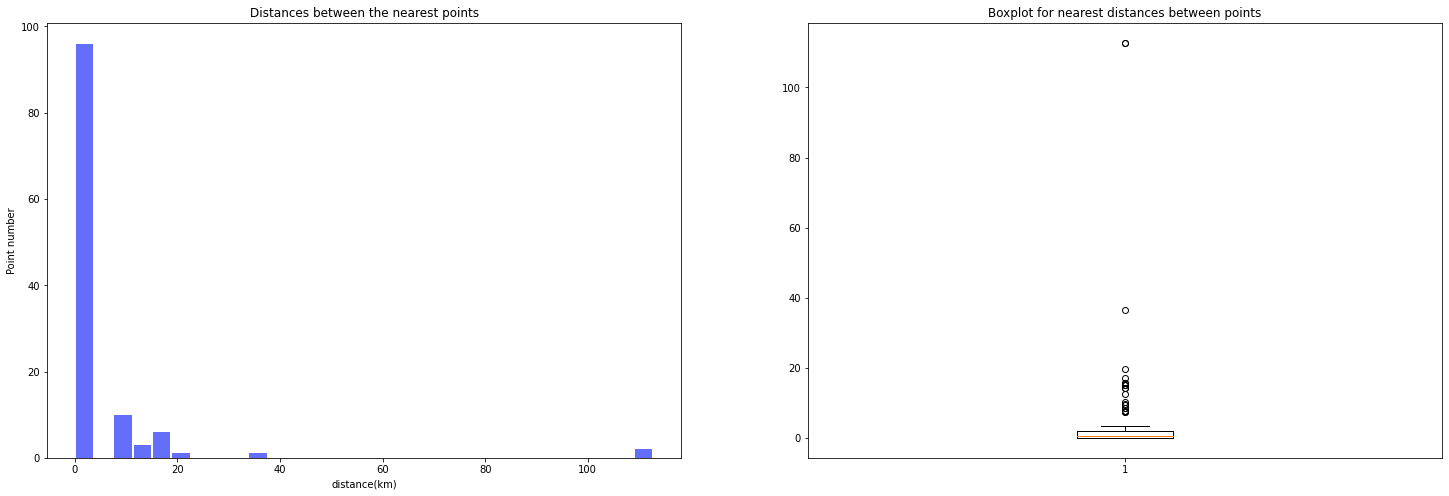

In [0]:
fig, axs = plt.subplots(1,2, figsize=(25,8))
axs[0].hist(x = df_points_dist.distances, bins=30, rwidth=0.9, color='#636efa')
#df_points_dist.distances.plot.hist(grid=True, bins=10, rwidth=0.9, color='#636efa')
axs[0].set_title('Distances between the nearest points')
axs[0].set_xlabel('distance(km)')
axs[0].set_ylabel('Point number')
#axs[0].set_grid(axis='y', alpha=0.75)

axs[1].boxplot(df_points_dist.distances)
axs[1].set_title('Boxplot for nearest distances between points')

In [0]:
print("mean {} km".format(np.mean(df_points_dist.distances)))
print("variance {}".format(np.var(df_points_dist.distances)))

mean 4.757529808529499 km
variance 229.82434493262843


In [0]:
import scipy.stats as scp
df_points_dist_per_region = df_points_dist['Autonomia'].value_counts().rename_axis('Autonomia').reset_index(name='count_point')
#df_points_dist_per_region["mean"] = [df_points_dist[df_points_dist["Autonomia"] == row_i["Autonomia"]].distances.mean for index_i, row_i in df_points_dist_per_region.iterrows()]
df_points_dist_per_region["mean"] = [np.mean(df_points_dist[df_points_dist["Autonomia"] == row_i["Autonomia"]].distances.tolist()) 
                                      for index_i, row_i in df_points_dist_per_region.iterrows()
                                    ]
df_points_dist_per_region["sd_deviation"] = [scp.sem(df_points_dist[df_points_dist["Autonomia"] == row_i["Autonomia"]].distances.tolist()) 
                                      for index_i, row_i in df_points_dist_per_region.iterrows()
                                    ]

#h = se * scp.t.ppf((1 + confidence) / 2., n-1)
    #return m, m-h, m+h                         
df_points_dist_per_region

,Autonomia,count_point,mean,sd_deviation
0,principado de asturias,95,2.783426,4.736549e-01
1,comunidad valenciana,10,0.001504,2.495209e-04
2,andalucia,4,0.000753,7.673644e-05
3,pais vasco,3,22.336990,7.158657e+00
4,cantabria,3,3.041947,2.362897e+00
5,castilla y leon,2,112.777540,2.203828e-13
6,region de murcia,2,0.005298,0.000000e+00


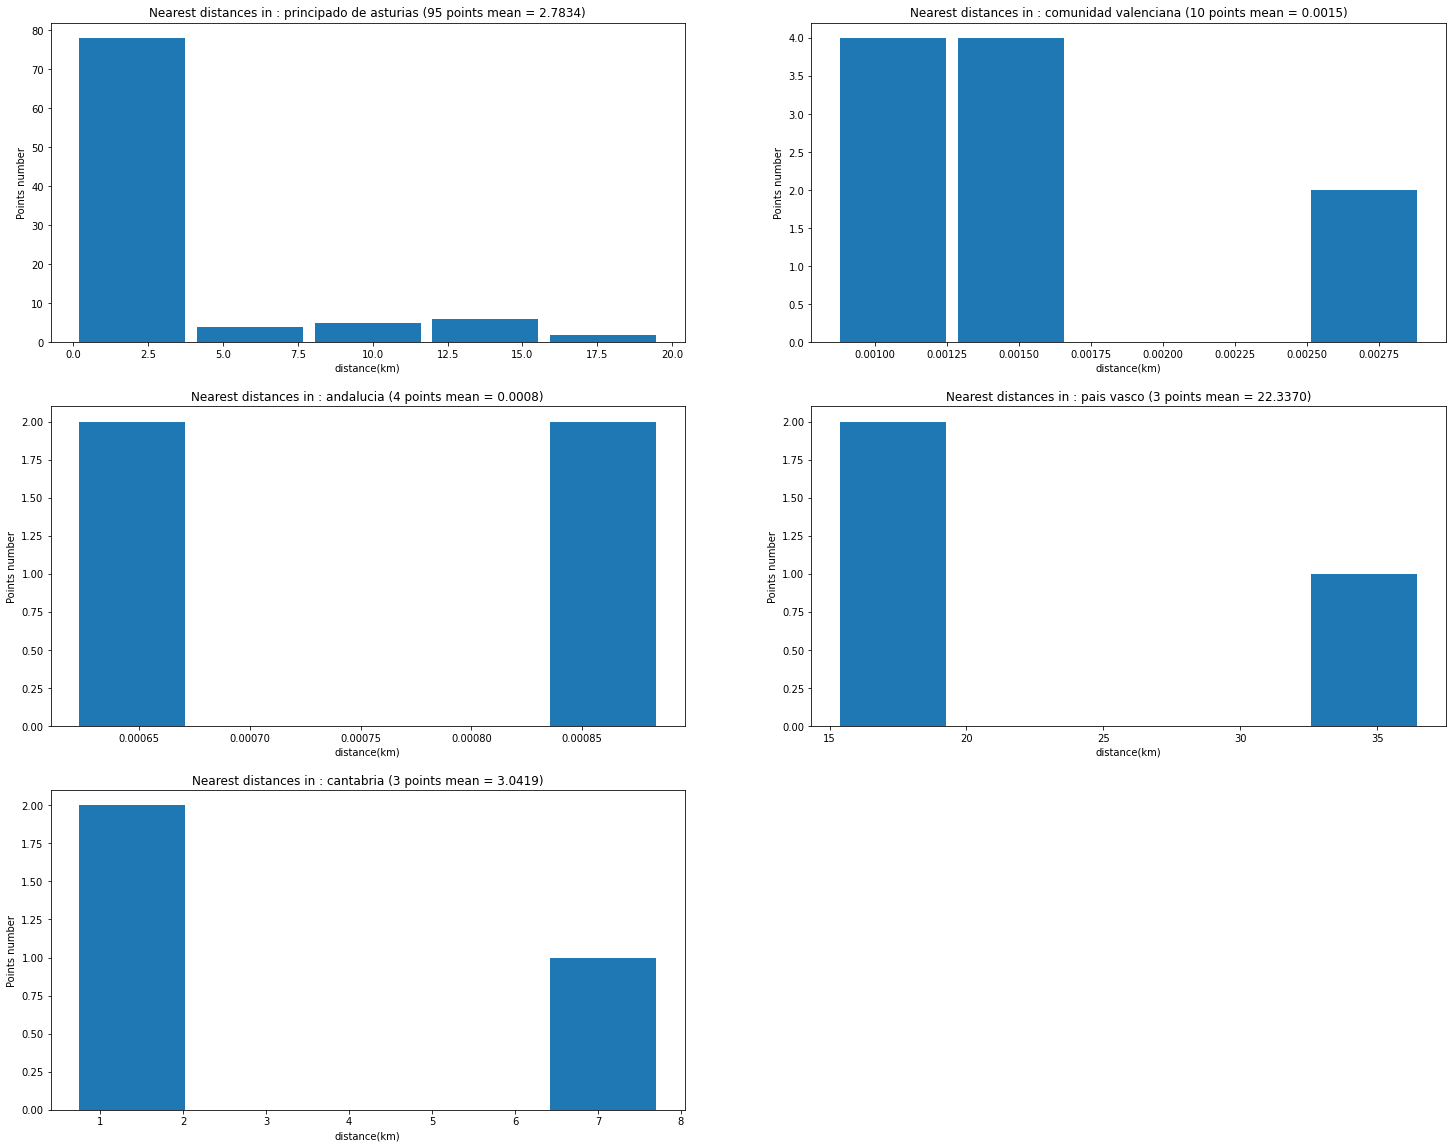

In [0]:
nb_autonomia=0
for index_i, row_i in df_points_dist_per_region.iterrows():
  if row_i.count_point > 2:
    nb_autonomia+=1
nb_autonomia
#plt.subplots(nb_autonomia, sharey = True)
ncols = 2
nrows = nb_autonomia//2 + nb_autonomia%2
fig = plt.figure(figsize=(25,20))
plt.gcf().subplots_adjust( wspace = 0.2, hspace = 0.2)
#plt.rc_context({'xtick.color':'red', 'ytick.color':'green', 'figure.facecolor':'white'})
plt.rc_context({'figure.facecolor':'white'})
i = 1
for index_i, row_i in df_points_dist_per_region.iterrows():
  if row_i.count_point > 2:
    axs = fig.add_subplot(nrows, ncols, i )
    
    axs.hist(x = df_points_dist[df_points_dist["Autonomia"] == row_i["Autonomia"]].distances.tolist(), bins=5, rwidth=0.9)
    axs.set_title('Nearest distances in : {} ({} points mean = {:.4f})'.format(row_i["Autonomia"], row_i["count_point"], row_i["mean"]))
    axs.set_xlabel('distance(km)')
    axs.set_ylabel('Points number')
    i+= 1

In [0]:
df_points_dist_per_region

,Autonomia,count_point,mean,sd_deviation
0,principado de asturias,95,2.783426,4.736549e-01
1,comunidad valenciana,10,0.001504,2.495209e-04
2,andalucia,4,0.000753,7.673644e-05
3,pais vasco,3,22.336990,7.158657e+00
4,cantabria,3,3.041947,2.362897e+00
5,castilla y leon,2,112.777540,2.203828e-13
6,region de murcia,2,0.005298,0.000000e+00


It appears that in the autonomia:
* Asturia: the ~100 points are ~3 km around each other
* Valancia: the 10 points are almost at the same location 
* Adalucia: the 4 poitns
* Cantabria: the 3 points
* Pais Vasco: the 3 points
* Castilla y leon: not enough points to talk
* Murcia: not enough points to talk

2 strategies could be relevant:
* Put the new points in the biggets traffic are, like in Asturia, especially if we consider that the electric cars are used to commuting for short distances.
* Put the new points to allow to travel throughout Spain.

2 - explore the areas containing most of the points

In [0]:
df_points.info()

In [0]:
list_coord_points = np.array( [[row_i["latitud"], row_i["longitud"]] for index_i, row_i in df_points.iterrows()])

In [0]:
import copy
import matplotlib

from matplotlib.colors import LogNorm
%matplotlib inline
#cmap = copy.copy(matplotlib.cm.jet)
#cmap.set_bad((0,0,0)) 
center = [40.4165001, -3.7025599]  #  Madrid location
radius=0.1
hist_range = [
    [center[1] - radius, center[1] + radius],
    [center[0] - radius, center[0] + radius]
]
print("center : {}".format(hist_range))
plt.hist2d(list(list_coord_points[:,0]), list(list_coord_points[:,1]), 
                bins=200, 
                norm=LogNorm(),
                cmap=cmap, 
                #range = hist_range
           )
plt.grid('off')
plt.axis('off')
#fig.axes[0].get_xaxis().set_visible(False)
#fig.axes[0].get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()
# c'est tout pourris

Plot point on a map

In [0]:
!pip install geopandas

In [0]:
!pip install topojson

In [0]:
# https://github.com/deldersveld/topojson/tree/master/countries/spain
import geopandas as gpd
import json

plt.rcParams['figure.figsize'] = (20, 10)
plt.rc_context({'figure.facecolor':'white'})
df = gpd.read_file('spain-provinces.json')
df.plot(color='grey', ax=ax,  alpha = 0.8)



<Figure size 1440x720 with 0 Axes>

In [0]:
#with open('spain-comunidad.json',"r") as json_file:
    #   with json.load(json_file) as json_file_load:
#df = pd.read_json('spain-comunidad.json')
crs = {'init': 'epsg:4326'}
geo_df_com = gpd.read_file('spain-comunidad.json', crs = crs)
geo_df_com.info()
#geo_df_com.scale(xfact = 0.00038734388431869277, yfact = 0.00027674749512036695)
#geo_df_com.affine_transform([0, 0, 0, 0, -9.298193999999967,35.280422000000044])
# Remove Island
geo_df_com = geo_df_com[geo_df_com["NAME_1"] != "Islas Baleares"]
geo_df_com = geo_df_com[geo_df_com["NAME_1"] != "Ceuta y Melilla"]

geo_df_com['coord_label'] = geo_df_com['geometry'].apply(lambda x: x.representative_point().coords[:])
geo_df_com['coord_label'] = [coords[0] for coords in geo_df_com['coord_label']]


#geo_df_com.head()
fig, ax = plt.subplots(1,1)
# plot background map
geo_df_com.plot(color='grey', ax = ax, alpha = 0.8)

In [0]:
# https://github.com/rylativity/identifying_wnv_locations-raw_repo-/blob/master/03-Geo_modeling.ipynb
from shapely.geometry import Point, Polygon
df_points_dist = pd.DataFrame()
geometry = [Point(row_i["longitud"], row_i["latitud"]) for index_i, row_i in df_merged_w_points.drop_duplicates().dropna().iterrows()
                                ]
geo_points = gpd.GeoDataFrame(geometry = geometry, crs = crs)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



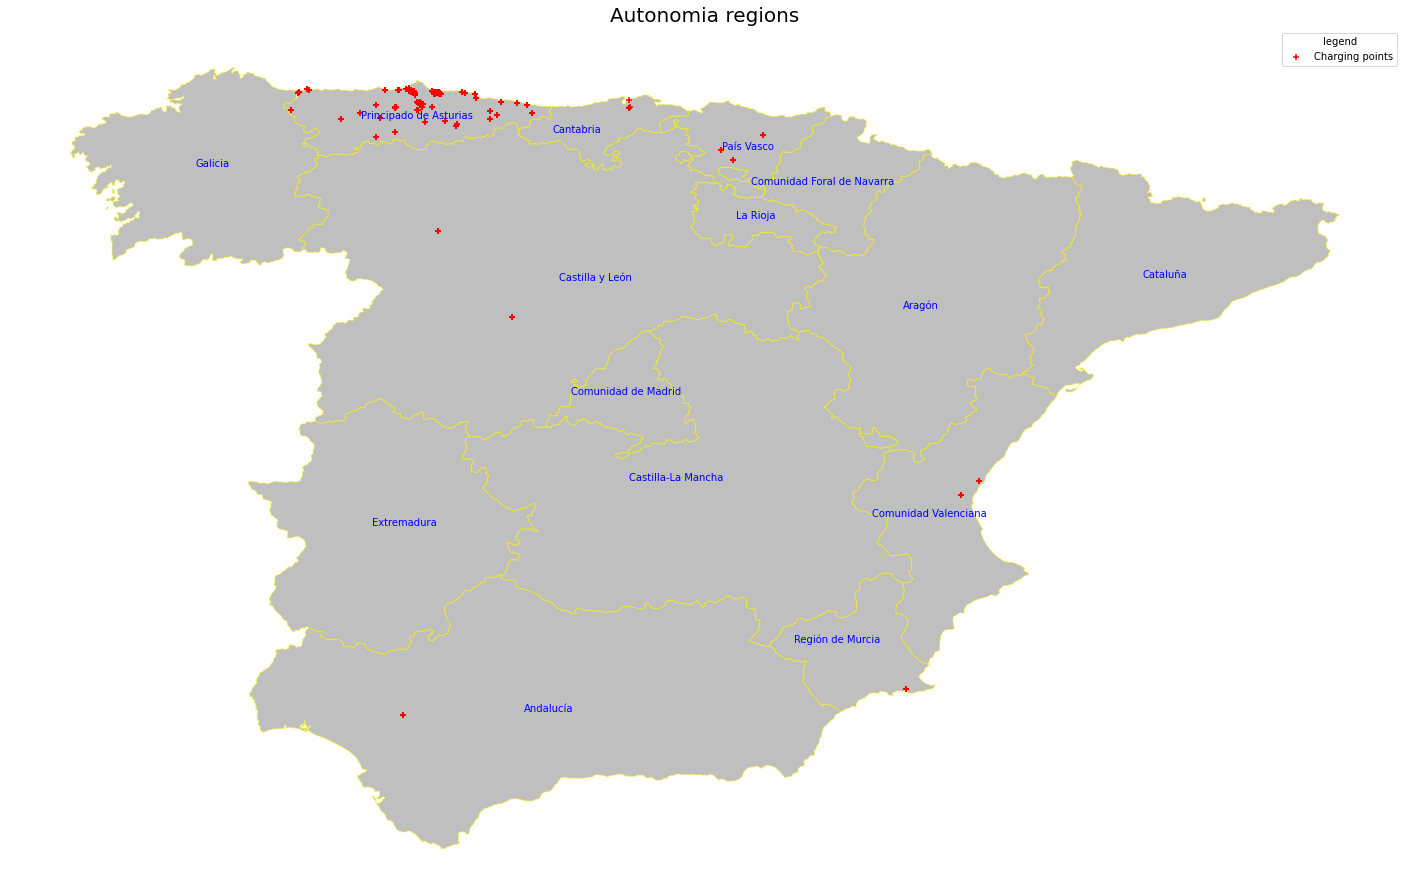

In [0]:
fig, ax = plt.subplots(1,1,figsize = (25, 25))
# plot background map
geo_df_com.plot(color='grey', ax = ax, alpha = 0.5, edgecolor='yellow', legend=True)
ax.set_title("Autonomia regions", fontsize=20)
# plot autonomia region name
for idx, row in geo_df_com.iterrows():
    plt.annotate(s=row['NAME_1'], xy=row['coord_label'],
                 horizontalalignment='center',color='blue')
# plot point
geo_points.plot(marker = '+', color='red', ax=ax, label = "Charging points", markersize = 40, legend = True)
ax.legend(title="legend")
ax.set_axis_off()
ax.set_axis_off()
# TODO : ajouter route et principales villes

In [0]:
# test if Madrid is in the map 
p_test = Point(40.4167754, -3.7037902)  # Madrid coords
test = [ p_test.within(poly["geometry"]) for key, poly in geo_df_com.iterrows()]
bool_test = True
for i in test : bool_test &= i
print("Madrid is inside ? : {}".format(bool_test))

## Dashboard

In [0]:
!pip install chart_studio
!pip install dash

In [0]:
import dash_core_components
print(dash_core_components.__version__)

1.10.0


In [0]:
import chart_studio.dashboard_objs as dashboard
import plotly.graph_objs as go
import chart_studio.plotly as py
import numpy as np

colorscale = [[0, '#FAEE1C'], [0.33, '#F3558E'], [0.66, '#9C1DE7'], [1, '#581B98']]
trace1 = go.Scatter(
    y = np.random.randn(500),
    mode='markers',
    marker=dict(
        size=16,
        color = np.random.randn(500),
        colorscale=colorscale,
        showscale=True
    )
)
data = [trace1]
url_1 = py.plot(data, filename='scatter-for-dashboard', auto_open=False)
py.iplot(data, filename='scatter-for-dashboard')

PlotlyRequestError: ignored

In [0]:
import plotly.graph_objects as go # or plotly.express as px
fig = go.Figure() # or any Plotly Express function e.g. px.bar(...)
# fig.add_trace( ... )
# fig.update_layout( ... )

import dash
import dash_core_components as dcc
import dash_html_components as html

app = dash.Dash()
app.layout = html.Div([
    dcc.Graph(figure=fig)
])

app.run_server(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter

Running on http://127.0.0.1:8050/
Debugger PIN: 382-971-768
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


In [0]:
!python app.py

Running on http://127.0.0.1:8050/
Debugger PIN: 266-612-150
 * Serving Flask app "app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
Running on http://127.0.0.1:8050/
Debugger PIN: 040-068-791


# Premier jet

In [0]:
#One-Hot Encoding
df_merged_dummy = pd.concat([pd.get_dummies(df_merged['Autonomia']), df_merged[['count_point', 'count_veh']]], axis=1)
df_merged_dummy

In [0]:
#Entrainement d'un modele KMeans
from sklearn.cluster import KMeans

n_clusters = 3
X = df_merged_dummy.values
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)

In [0]:
#Check des corrdonées des centroides
kmeans.cluster_centers_

In [0]:
#Dimensionality reduction
from sklearn.decomposition import PCA
# Check we can stop at Dim 2
n_components = 4
pca = PCA(n_components=n_components)
pca.fit(X)
print("\n -----explained_variance_ratio_---")
print(pca.explained_variance_ratio_)

n_components = 2
pca = PCA(n_components=n_components)
pca.fit(X)
X_reduced = pca.fit_transform(X)

In [0]:
#Points en 
import matplotlib.pyplot as plt

plt.scatter(X_reduced[:, 0], X_reduced[:, 1])

In [0]:
n_components = 2
pca_center = PCA(n_components=n_components)
center_reduced = pca_center.fit_transform(kmeans.cluster_centers_)
plt.scatter(center_reduced[:, 0], center_reduced[:, 1])

In [0]:
#It will be really helpful if we can present all the result we find in a dashbord
#using this link we have all the tools
#https://dash-gallery.plotly.host/dash-manufacture-spc-dashboard/
#this exemple of dahboard is really interesting !!